In [1]:
import numpy as np
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import time
import cv2
from cameraCoppelia import CameraCoppelia, world_to_pixel_coordinates, pixel_to_world_coordinates
import matplotlib.pyplot as plt

In [2]:
client = RemoteAPIClient()
client.setStepping(True)

0

In [3]:
sim = client.getObject('sim')
# 2) Handles
robot_handle  = sim.getObject('/PioneerP3DX')
robot_gps_handle = sim.getObject('/PioneerP3DX/GPS')
goal_gps_handle = sim.getObject('/goal/gps')

camera = CameraCoppelia(sim, '/SkyCamera')

In [4]:
K,W,H = camera.getIntrinsics()
R_wc, t_wc = camera.getExtrinsics()
print('Intrinsics:', K)
print('Extrinsics:', R_wc, t_wc)

Intrinsics: [[1.03733035e+03 0.00000000e+00 5.40000000e+02]
 [0.00000000e+00 1.03733035e+03 5.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Extrinsics: [[-1.00000000e+00 -2.06623947e-13  9.41833417e-14]
 [-2.06623947e-13  1.00000000e+00 -2.06179858e-13]
 [-9.41833417e-14 -2.06179858e-13 -1.00000000e+00]] [[-4.70916708e-13]
 [ 1.03089929e-12]
 [ 5.00000000e+00]]


In [5]:
# Obtaining Robot 3D World Position
robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
print('Robot Position:', robot_pos)

Robot Position: [-1.7160166261868177, -1.7466462239848168, 0.1386864167792596]


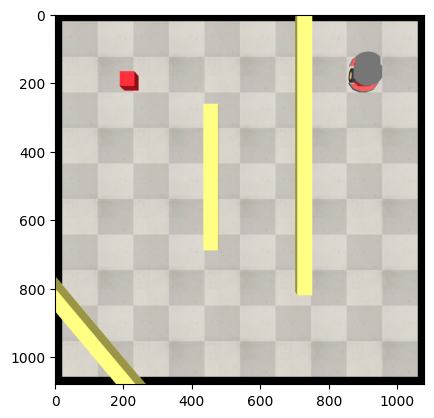

In [6]:
sim.startSimulation()
client.step()
time.sleep(1)
frame, resx, resy = camera.getFrame()
plt.imshow(frame)
sim.stopSimulation()
time.sleep(1)

In [7]:
def depth_on_floor(camera, u, v):
    """
    Compute the camera‐frame depth Z_c of the ray through pixel (u,v)
    that hits the world‐floor Z_w=0.
    """
    # 1) Get intrinsics & extrinsics
    K, W, H      = camera.getIntrinsics()
    R_wc, t_wc   = camera.getExtrinsics()   # world→camera
    R_c2w        = R_wc.T                   # camera→world
    C_w          = -R_c2w @ t_wc            # camera center in world coords (3×1)

    # 2) Ray direction in camera frame
    K_inv        = np.linalg.inv(K)
    ray_cam      = (K_inv @ np.array([u, v, 1.0]).reshape(3,1)).flatten()  # 3-vector

    # 3) Express ray in world coords:
    #    X_w(s) = C_w + s*(R_c2w @ ray_cam)
    ray_w        = (R_c2w @ ray_cam.reshape(3,1)).flatten()  # 3-vector direction
    Cz           = C_w[2,0]                                  # camera’s world-Z
    dz           = ray_w[2]                                  # direction’s world-Z

    if abs(dz) < 1e-6:
        return None  # parallel to floor, no intersection

    # solve C_w.z + s*dz = 0  →  s = -Cw_z / dz
    s = -Cz / dz

    # now depth in camera frame is s * (ray_cam’s Z component)
    depth = s * ray_cam[2]

    return float(depth)


Robot Position: [-1.7249586363523437, -1.7002731240839941, 0.13870434688556943]
Robot Position in Image: 908.0812835071652 177.1862486230206
Estimated Robot Position [-1.72495864 -1.70027312  0.13870435]
Robot Position: [-1.7249635359674924, -1.7005408858134508, 0.13869831146105469]
Robot Position in Image: 908.0818720311596 177.12956264654855
Estimated Robot Position [-1.72496354 -1.70054089  0.13869831]


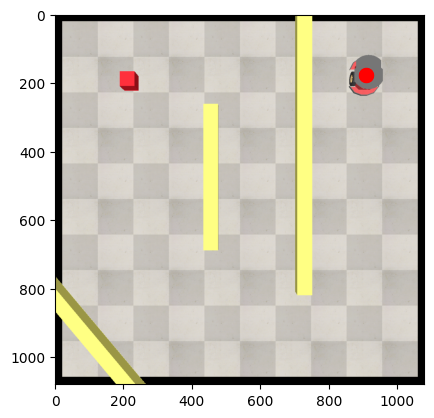

In [8]:
sim.startSimulation()
for _ in range(2):
    time.sleep(0.5)
    cv2_frame, resx, resy = camera.getFrame()
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    u,v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])
    print('Robot Position in Image:', u, v)
    # Distance from camera to robot
    # recompute p_c (or reuse it if you stored it) to get Z_c
    p_w = np.array(robot_pos).reshape(3,1)
    p_c = R_wc @ p_w + t_wc
    depth = p_c[2,0]    # <-- the *true* Z_c in camera frame

    print("Estimated Robot Position", pixel_to_world_coordinates(camera, (u,v), depth))

    plt.scatter(u, v, color='red', s=100, label='Robot Position in Image')
    plt.imshow(cv2_frame)
    client.step()
sim.stopSimulation()

In [9]:
def segment_yellow_borders(img_rgb):
    # 1) Convert to HSV
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

    # 2) Define yellow range (tune these!)
    lower = np.array([20, 100, 100])
    upper = np.array([40, 255, 255])

    # 3) Threshold
    mask = cv2.inRange(hsv, lower, upper)

    # 4) (Optional) Morphological closing to fill gaps
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # 5) (Optional) Erosion to remove noise
    mask = cv2.erode(mask, kernel, iterations=1)

    # Inverting Colors
    #mask = cv2.bitwise_not(mask)

    return mask


In [10]:
def extract_wall_lines(mask, 
                        rho=1, 
                        theta=np.pi/180, 
                        threshold=10, 
                        min_line_length=10, 
                        max_line_gap=10):
    """
    Detects dominant straight borders in a binary mask using Probabilistic Hough Transform.
    Returns a list of line segments, each as ((x1, y1), (x2, y2)).
    """
    # 1) Edge detection
    edges = cv2.Canny(mask, 50, 150, apertureSize=3)

    # 2) Hough line detection (Probabilistic)
    raw_lines = cv2.HoughLinesP(edges,
                                rho=rho,
                                theta=theta,
                                threshold=threshold,
                                minLineLength=min_line_length,
                                maxLineGap=max_line_gap)
    if raw_lines is None:
        return []

    # 3) Collect and optionally merge near‐collinear segments
    lines = [((x1, y1), (x2, y2)) for x1, y1, x2, y2 in raw_lines[:,0]]

    # 4) (Optional) Merge lines with similar angle and close distance
    merged = []
    for line in lines:
        added = False
        (x1, y1), (x2, y2) = line
        angle = np.arctan2(y2 - y1, x2 - x1)
        for m in merged:
            (mx1, my1), (mx2, my2), mangle = m
            if abs(np.sin(angle - mangle)) < 0.1:
                # endpoints close?
                if (np.hypot(x1-mx1, y1-my1) < 20 or 
                    np.hypot(x1-mx2, y1-my2) < 20 or
                    np.hypot(x2-mx1, y2-my1) < 20 or
                    np.hypot(x2-mx2, y2-my2) < 20):
                    # merge by extending endpoints
                    pts = np.array([[x1,y1],[x2,y2],[mx1,my1],[mx2,my2]])
                    dists = pts.dot([np.cos(angle), np.sin(angle)])
                    idx_min, idx_max = np.argmin(dists), np.argmax(dists)
                    new_p1 = tuple(pts[idx_min])
                    new_p2 = tuple(pts[idx_max])
                    m[:] = [new_p1, new_p2, angle]
                    added = True
                    break
        if not added:
            merged.append([ (x1,y1), (x2,y2), angle ])

    # strip angles
    wall_lines = [ (l[0], l[1]) for l in merged ]
    return wall_lines


In [11]:
def polyline_to_grid(polyline3d, origin, resolution, width, height):
    """
    polyline3d: Nx3 world points
    origin: (x0,y0) bottom‐left corner of grid
    resolution: meters per cell
    width, height: number of cells
    """
    grid = np.zeros((height, width), dtype=np.uint8)
    pts2d = [((p[0]-origin[0])/resolution, (p[1]-origin[1])/resolution) for p in polyline3d]
    for i in range(len(pts2d)-1):
        x1,y1 = pts2d[i]
        x2,y2 = pts2d[i+1]
        cv2.line(grid, 
                (int(x1),int(y1)), 
                (int(x2),int(y2)),
                color=1, thickness=1)
    return grid


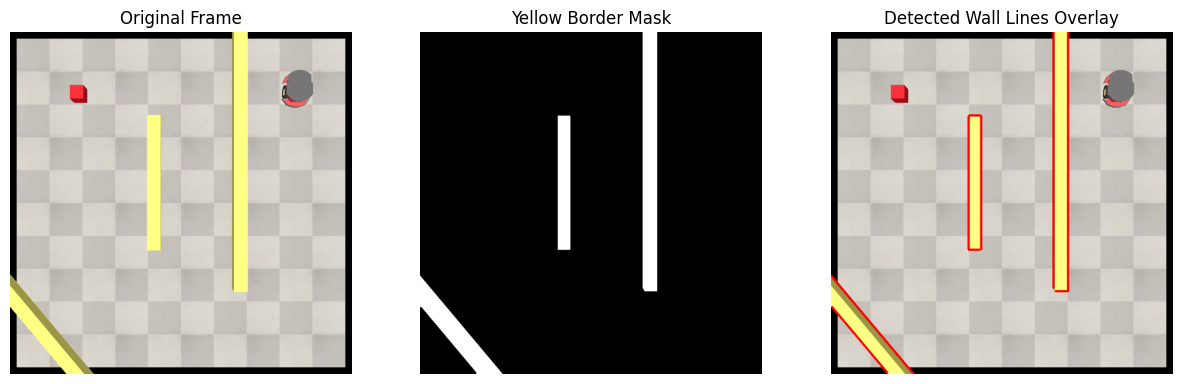

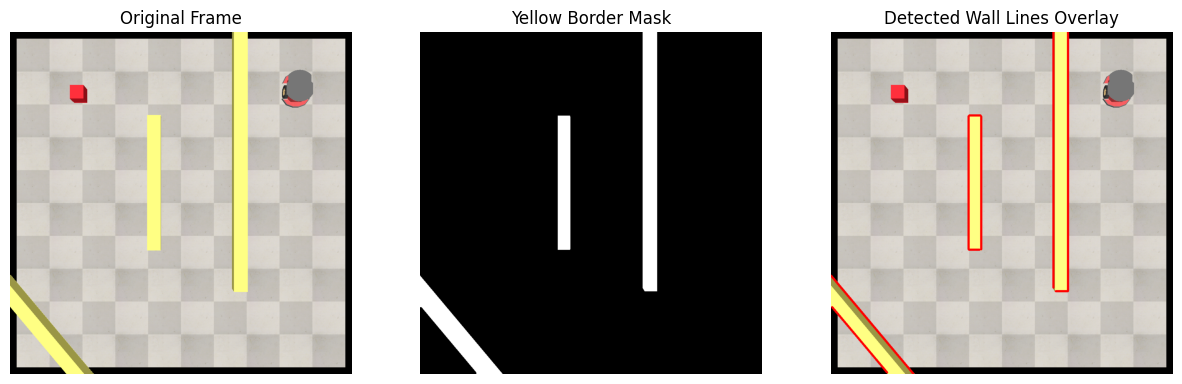

In [12]:
sim.startSimulation()
for _ in range(2):
    time.sleep(0.5)

    # 1. Grab image & segment
    frame, _, _ = camera.getFrame()
    mask = segment_yellow_borders(frame)

    # 2. Extract straight wall segments in pixel coords
    walls_uv = extract_wall_lines(mask)

    # 3. Draw lines on a copy of the frame
    frame_with_lines = frame.copy()
    for (u1, v1), (u2, v2) in walls_uv:
        cv2.line(frame_with_lines, (int(u1), int(v1)), (int(u2), int(v2)), (255, 0, 0), 5)

    # 4. Plot original frame, mask, and frame with lines
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(frame)
    plt.title('Original Frame')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Yellow Border Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(frame_with_lines)
    plt.title('Detected Wall Lines Overlay')
    plt.axis('off')

    plt.show()
    client.step()
sim.stopSimulation()


# DOING A Start

In [13]:
import heapq

def astar(grid, start, goal):
    H, W = grid.shape
    def heuristic(a, b):
        return np.hypot(b[0] - a[0], b[1] - a[1])

    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), 0, start))
    came_from = {}
    g_score = {start: 0}

    while open_set:
        _, cost, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for dx, dy in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
            neighbor = (current[0] + dx, current[1] + dy)
            if 0 <= neighbor[0] < H and 0 <= neighbor[1] < W and grid[neighbor] != 0:
                tentative_g = g_score[current] + heuristic(current, neighbor)
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    g_score[neighbor] = tentative_g
                    f = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f, tentative_g, neighbor))
                    came_from[neighbor] = current
    return None  # No path found


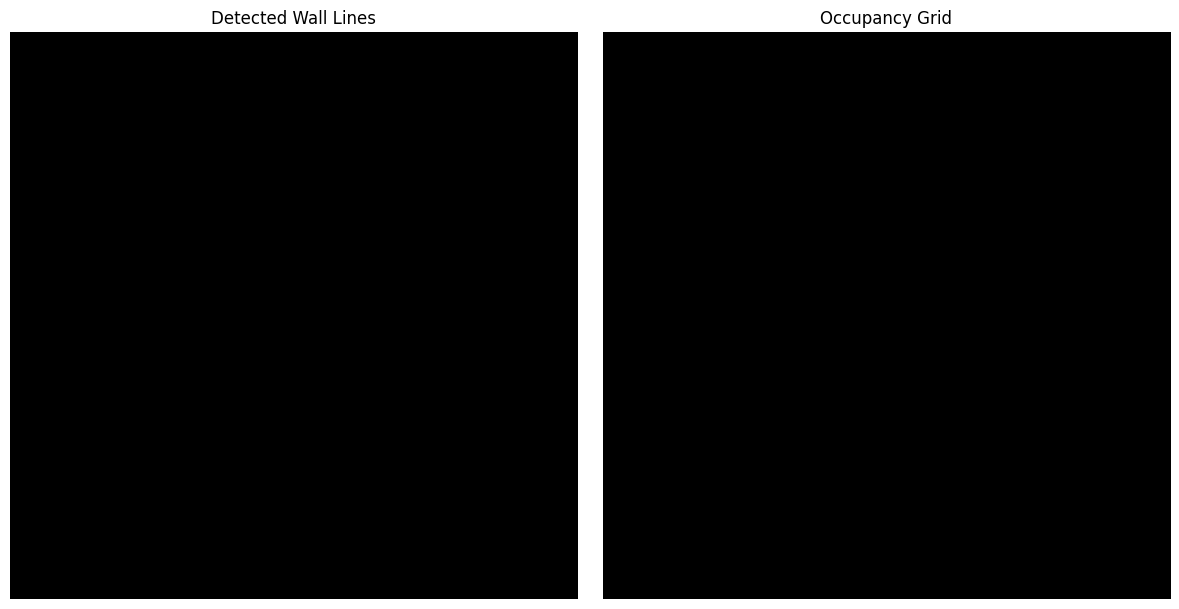

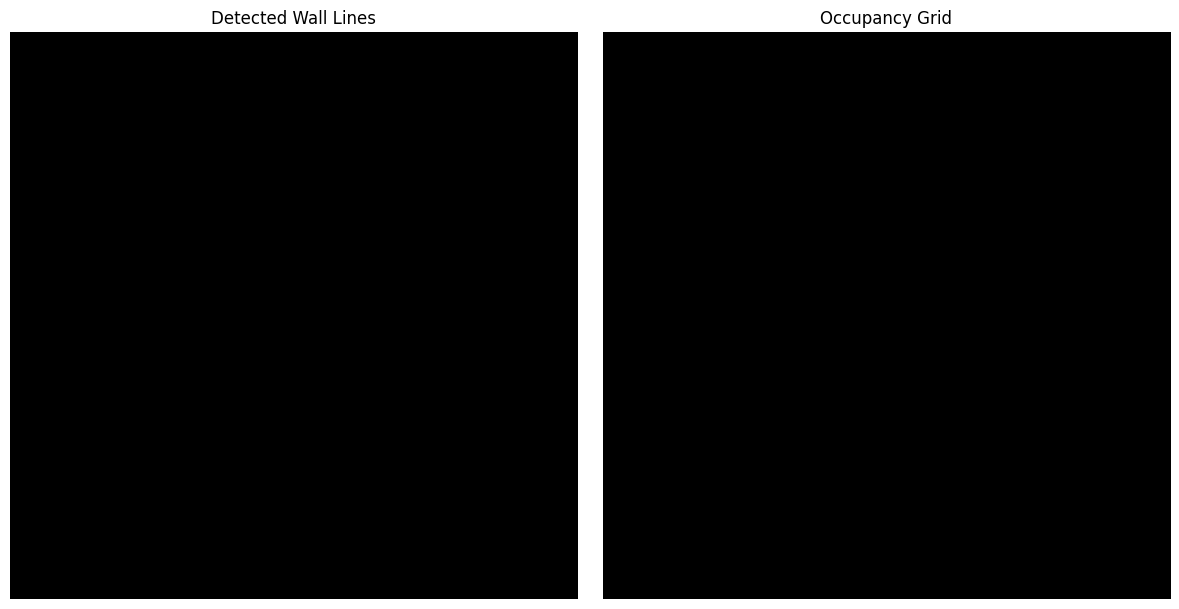

In [14]:
sim.startSimulation()
for _ in range(2):
    time.sleep(0.5)

    # 1. Grab image & segment
    frame, _, _ = camera.getFrame()
    mask = segment_yellow_borders(frame)

    # 2. Extract straight wall segments in pixel coords
    walls_uv = extract_wall_lines(mask)

    # 3. Draw lines on a copy of the frame
    frame_with_lines = frame.copy()
    for (u1, v1), (u2, v2) in walls_uv:
        cv2.line(frame_with_lines, (int(u1), int(v1)), (int(u2), int(v2)), (255, 0, 0), 5)

    grid = np.ones_like(mask, dtype=np.uint8)  # 1 = free, 0 = occupied

    for (u1, v1), (u2, v2) in walls_uv:
        cv2.line(grid, (u1, v1), (u2, v2), 0, thickness=3)  # 0 = obstacle

    # Plot the frame with blue wall lines
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame_with_lines, cv2.COLOR_BGR2RGB))
    plt.title("Detected Wall Lines")
    plt.axis("off")

    # Plot the binary grid (1 = free, 0 = obstacle)
    plt.subplot(1, 2, 2)
    plt.imshow(grid, cmap='gray')
    plt.title("Occupancy Grid")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


    client.step()
sim.stopSimulation()


Robot Position: [-1.7249586363523437, -1.7002731240839941, 0.13870434688556943]
Goal Position: [1.524999999999977, -1.6249999999981841, 0.188790089405846]


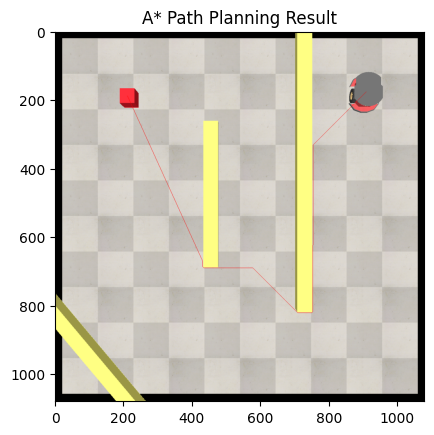

Robot Position: [-1.7244922884327332, -1.7062810306194016, 0.13869054584578525]
Goal Position: [1.5250000000000075, -1.6250000000009532, 0.1887900894066849]


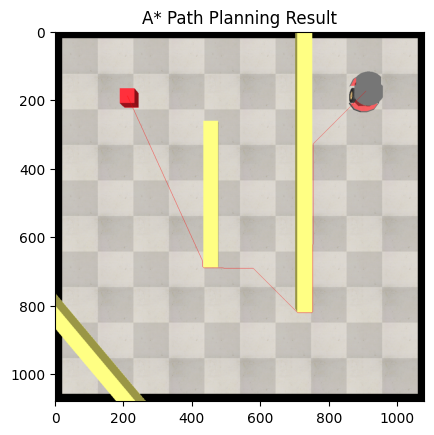

In [15]:
sim.startSimulation()
for _ in range(2):
    time.sleep(0.5)
    cv2_frame, resx, resy = camera.getFrame()

    # 1. Get Robot and Goal Positions (in world coordinates)
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    robot_u, robot_v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])

    goal_pos = sim.getObjectPosition(goal_gps_handle, -1)
    print('Goal Position:', goal_pos)
    goal_u, goal_v = world_to_pixel_coordinates(camera, goal_pos[0], goal_pos[1], goal_pos[2])  # pixel coordinates

    # 2. Segment walls from image
    mask = segment_yellow_borders(cv2_frame)

    # 3. Extract walls using Hough transform
    walls_uv = extract_wall_lines(mask)

    # 4. Create occupancy grid (1 = free, 0 = obstacle)
    grid = np.ones_like(mask, dtype=np.uint8)  # shape=(H,W)
    for (u1, v1), (u2, v2) in walls_uv:
        cv2.line(grid, (u1, v1), (u2, v2), 0, thickness=3)

    # Optional: make walls thicker to account for robot size
    kernel = np.ones((3,3), np.uint8)
    grid = cv2.erode(grid, kernel)

    # 5. Run A* on the grid
    x_start, y_start = int(robot_u), int(robot_v)
    x_goal,  y_goal  = int(goal_u),  int(goal_v)

    start = (y_start, x_start)  # (row, col)
    goal  = (y_goal, x_goal)

    path = astar(grid, start, goal)

    # 6. Visualize result
    if path:
        for (y, x) in path:
            cv2_frame[y, x] = (255, 0, 0)  # green path
        plt.imshow(cv2_frame)
        plt.title('A* Path Planning Result')
        plt.show()
    else:
        print("No path found.")

    client.step()
sim.stopSimulation()

# Motion Planning

Robot Position: [-1.7249531217238887, -1.7002493435308608, 0.1387036488181928]
Goal Position: [1.5249999999998587, -1.624999999999625, 0.18879008306876605]


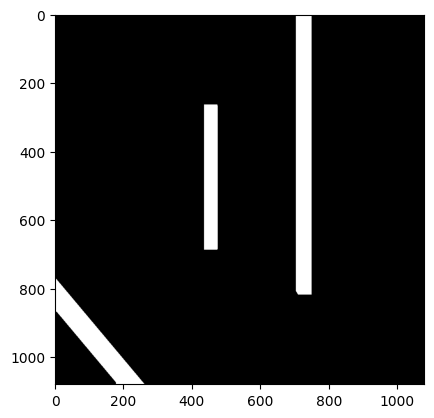

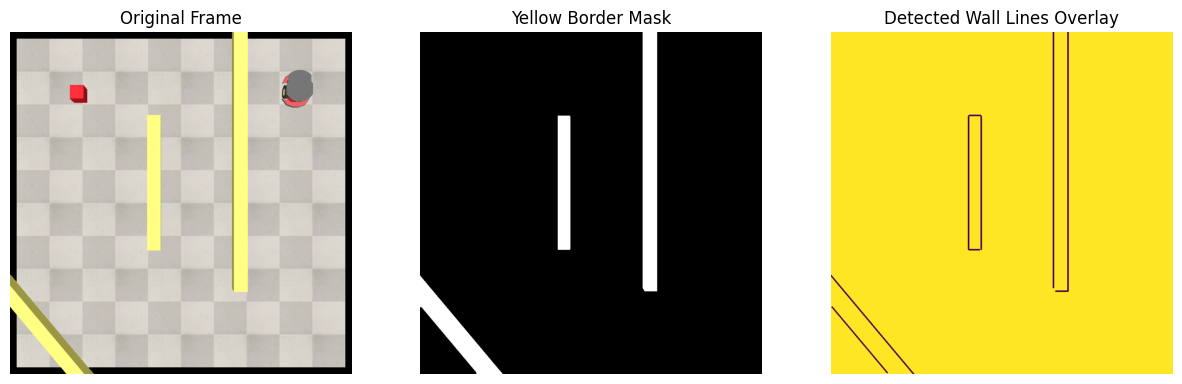

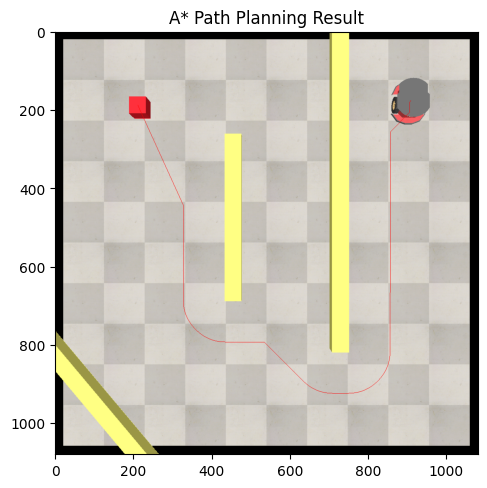

In [19]:
sim.startSimulation()
for _ in range(1):
    time.sleep(0.5)
    cv2_frame, resx, resy = camera.getFrame()

    # 1. Get Robot and Goal Positions (in world coordinates)
    robot_pos = sim.getObjectPosition(robot_gps_handle, -1)
    print('Robot Position:', robot_pos)
    robot_u, robot_v = world_to_pixel_coordinates(camera, robot_pos[0], robot_pos[1], robot_pos[2])

    goal_pos = sim.getObjectPosition(goal_gps_handle, -1)
    print('Goal Position:', goal_pos)
    goal_u, goal_v = world_to_pixel_coordinates(camera, goal_pos[0], goal_pos[1], goal_pos[2])  # pixel coordinates

    # 2. Segment walls from image
    mask = segment_yellow_borders(cv2_frame)

    plt.imshow(mask, cmap='gray')

    # 3. Extract walls using Hough transform
    walls_uv = extract_wall_lines(mask)


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2_frame)
    plt.title('Original Frame')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Yellow Border Mask')
    plt.axis('off')

    # 4. Create occupancy grid (1 = free, 0 = obstacle)
    grid = np.ones_like(mask, dtype=np.uint8)  # shape=(H,W)
    for (u1, v1), (u2, v2) in walls_uv:
        cv2.line(grid, (u1, v1), (u2, v2), 0, thickness=3)

    plt.subplot(1, 3, 3)
    plt.imshow(grid)
    plt.title('Detected Wall Lines Overlay')
    plt.axis('off')

    # Optional: make walls thicker to account for robot size
    kernel = np.ones((3,3), np.uint8)
    grid = cv2.erode(grid, kernel)

    # Convertir dimensiones del robot a píxeles
    K, W, H = camera.getIntrinsics()
    fx = K[0, 0]
    fy = K[1, 1]

    # Robot ocupa una elipse/círculo de radio aproximadamente (en píxeles)
    robot_radius_x_px = int((0.2 / 2.0) * fx)
    robot_radius_y_px = int((0.2 / 2.0) * fy)

    # Crear el kernel elíptico (estructura del robot)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * robot_radius_x_px, 2 * robot_radius_y_px))

    # Inflar los obstáculos (0s) para que representen el espacio de colisión
    inflated_grid = cv2.dilate(1 - grid, kernel)  # Invertir para que los obstáculos sean 1s → dilatar → revertir
    inflated_grid = 1 - inflated_grid  # Volver a formato 1=libre, 0=obstáculo

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(inflated_grid, cmap='gray')
    plt.title('Inflated Occupancy Grid')    

    # A*
    start = (int(robot_v), int(robot_u))  # asegúrate de usar coordenadas y,x
    goal  = (int(goal_v), int(goal_u))
    path = astar(inflated_grid, start, goal)

    if path:
        # Visualización
        for (y, x) in path:
            cv2_frame[y, x] = (255, 0, 0)  # green path

        plt.imshow(cv2_frame)
        plt.title('A* Path Planning Result')
        plt.show()
    else:
        print("No path found.")

    client.step()
sim.stopSimulation()

# Following the Proposed Route

In [ ]:
path_world = [pixel_to_world_coordinates(camera, (x, y), depth_on_floor(camera, x, y)) for (y, x) in path]

Robot Position: [-1.7249531217238887, -1.7002493435308608, 0.1387036488181928]
Goal Position: [1.5249999999998587, -1.624999999999625, 0.18879008306876605]


KeyboardInterrupt: 

In [ ]:
#client.setStepping(True)
#sim.startSimulation()


# time.sleep(0.5)  # esperar medio segundo antes de la primera lectura